This template notebook should serve as a guide for how to load and manipulate the dataset, and the different preprocessing methods you may choose to implement (you are welcome to try any others outside of what is provided here). This code should be treated as pseudo-code - and you may have to debug this code to get it working adequately.

In this notebook, we only access the labeled portion of the training dataset, and directly run/train/fit supervised methods. e.g., Multinomial Naive Bayes and Linear SGD classifiers (linear SGD [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html] implements regularized linear models with stochastic gradient descent, e.g., by choosing loss=‘log_loss’, you obtain a logistic regression classifier), on only this labeled portion of the training dataset. The performance values you get from running this experiment will serve as your baseline.

Once you have these baseline numbers for the configuration of preprocessing and supervised methods you choose (ideally at least 2 preprocessing methods and also at least 2 supervised methods), you can now begin working on Part 1: i.e. using unsupervised learning methods to automate adding labels to the unlabelled portion of the train dataset. The goal is to see if adding these newly labeled data examples to the train set will improve the baseline numbers you obtained (i.e. Part 2: running the supervised methods you chose for the baseline on the newly augmented dataset and reporting the performance on this augmented dataset).

Lastly, please note that there is a class imbalance in the train, test, and val sets. You will have to incorporate an approach to deal with this.

In [7]:
# e.g. if using google colab import drive, uncomment lines below
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
# import packages

import os
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression as sk_OLS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import math

from sklearn.metrics import r2_score
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

## Download the data

In [9]:
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

In [10]:
# get all train data (labelled and unlabelled)
X_train    = train_data['Phrase']
y_train    = train_data['Sentiment']

# get only labelled train data
mask = (y_train != -100)
train_data_clean    = train_data[mask]
X_train_clean    = X_train[mask]
y_train_clean    = y_train[mask]

# get val data
X_val    = val_data['Phrase']
y_val    = val_data['Sentiment']

# get test data
X_test     = test_data['Phrase']

print(f"Train Data Shape: {X_train.shape}")
print(f"Cleaned Train Data Shape: {train_data_clean['Phrase'].shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

print(" ")
print(f"Number of labels = 0 in train dataset as percentage: {((y_train == 0).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in train dataset as percentage: {((y_train == 3).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in train dataset as percentage: {((y_train == 4).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in train dataset as percentage: {((y_train == -100).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 0 in val dataset as percentage: {((y_val == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_val == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_val == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = -100 in val dataset as percentage: {((y_val == -100).sum() / (X_val.shape[0])) * 100:0.2f}%")

Train Data Shape: (59706,)
Cleaned Train Data Shape: (24758,)
Validation Data Shape: (23256,)
Test Data Shape: (23257,)
 
Number of labels = 0 in train dataset as percentage: 8.33%
Number of labels = 1 in train dataset as percentage: 8.95%
Number of labels = 2 in train dataset as percentage: 5.33%
Number of labels = 3 in train dataset as percentage: 9.60%
Number of labels = 4 in train dataset as percentage: 9.26%
Number of labels = -100 in train dataset as percentage: 58.53%
 
Number of labels = 0 in val dataset as percentage: 19.63%
Number of labels = 1 in val dataset as percentage: 20.27%
Number of labels = 2 in val dataset as percentage: 20.42%
Number of labels = 3 in val dataset as percentage: 19.81%
Number of labels = 4 in val dataset as percentage: 19.88%
Number of labels = -100 in val dataset as percentage: 0.00%


# Define Preprocessing Helper Functions

In [11]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(text), flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    #added substitutions

    #***********added substitutions***********
    # remove all the special characters
    texter = re.sub(r'\W', ' ', texter)
    # remove all single characters
    texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
    # Remove single characters from the start
    texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
    # Remove numbers
    texter = re.sub(r'\d+', ' ', texter)
    # Converting to Lowercase
    texter = texter.lower()
    # Remove punctuation
    texter = re.sub(r'[^\w\s]', ' ', texter)
    # Remove parentheses
    texter = re.sub(r'\([^)]*\)', ' ', texter)
    # Remove single quotes
    texter = re.sub(r'\'', ' ', texter)
    # Substituting multiple spaces with single space
    texter = re.sub(r'\s+', ' ', texter, flags=re.I)

    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def clean_dataset(dataset):
    for row in range(dataset.shape[0]):
        dataset[row,0] = clean(dataset[row,0])
    return dataset

def tokenize_lexicon(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(nltk.word_tokenize(texts[i]))
        return_texts[i] = nltk.pos_tag(return_texts[i])
    return return_texts

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

def lemmatize_texts(texts):
    return_texts = []
    lemmer = nltk.stem.WordNetLemmatizer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(lemmer.lemmatize(texts[i][j][0], pos=get_wordnet_pos(texts[i][j][1])))
    return return_texts

def stem_texts(texts):
    return_texts = []
    ps = PorterStemmer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(ps.stem(texts[i][j][0]))
    return return_texts


def backtostring(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(" ".join(texts[i]))
    return return_texts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Preprocess using Bag of Words

In [12]:
def pre_process(data):
    preproc_data = data.copy()
    preproc_data = preproc_data.str.lower()
    punctuation = string.punctuation
    mapping = str.maketrans("", "", punctuation)
    preproc_data = preproc_data.str.translate(mapping)
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    preproc_data = preproc_data.apply(lambda text: ' '.join([word for word in str(text).split() if word.lower() not in stop_words]))
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    preproc_data = preproc_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))
    preproc_data = preproc_data.apply(lambda text: re.sub(r'@\w+', '', re.sub(r'http\S+|www\S+', '', text)))
    return preproc_data

# get the preprocessed data
X_train_preproc   = pre_process(X_train)
X_train_clean_preproc   = pre_process(X_train_clean)
X_val_preproc = pre_process(X_val)
X_test_preproc = pre_process(X_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilygelchie/nltk_data...
[nltk_data]   Package st

Bag of words model

In [13]:
combined_data = pd.concat([X_train_preproc, X_val_preproc, X_test_preproc])

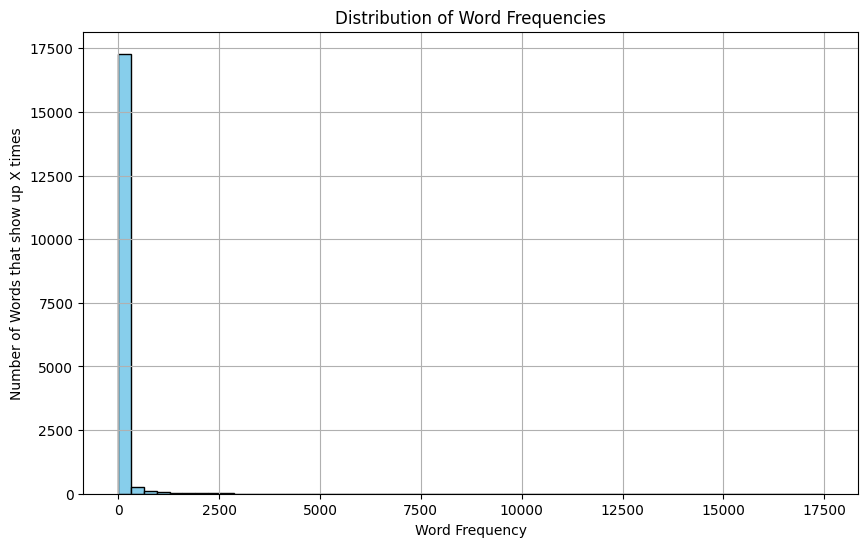

In [14]:
text_data = combined_data
words = ' '.join(text_data).split()
word_freq_dict = Counter(words)

word_frequencies = list(word_freq_dict.values())

plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=55, color='skyblue', edgecolor='black')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words that show up X times')
plt.title('Distribution of Word Frequencies')
plt.grid(True)
plt.show()

In [15]:
def bag_of_word(data,  threshold_M):
    vectorizer = CountVectorizer(binary=True, max_features= threshold_M)
    vectorizer.fit(combined_data)
    X = vectorizer.transform(data)
    featurized_data = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
    return featurized_data

# get the featurized data
X_train   = bag_of_word(X_train_preproc, 8)
X_train_clean = bag_of_word(X_train_clean_preproc, 8)
X_val = bag_of_word(X_val_preproc, 8)
X_test = bag_of_word(X_test_preproc, 8)

Sklearn Multinomial NB

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB(alpha=1e-3)
clf.fit(X_train_clean, y_train_clean)
sk_y = clf.predict(X_val)

In [17]:
print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 4.11%
Number of labels = 1 in val dataset as percentage: 11.18%
Number of labels = 2 in val dataset as percentage: 7.80%
Number of labels = 3 in val dataset as percentage: 71.02%
Number of labels = 4 in val dataset as percentage: 5.89%


Sklearn Linear SGD Classifier

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train_clean, y_train_clean)
y_pred = clf_sgd.predict(X_val)
# print("Feature Count \n",clf_sgd.feature_count_)
# print("Class Log Prior ",clf_sgd.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, y_pred))
# print(clf_sgd.predict_proba(X_test))

Accuracy:  0.2819487444100447


In [19]:
print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 0.01%
Number of labels = 1 in val dataset as percentage: 0.16%
Number of labels = 2 in val dataset as percentage: 7.90%
Number of labels = 3 in val dataset as percentage: 83.31%
Number of labels = 4 in val dataset as percentage: 8.62%


# Preprocess the data using CountVectorizer, nltk stem

In [20]:
import nltk

nltk.download("all")
# Add these downloads before the preprocessing code
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

lemma = True

# Rest of your code remains the same
train = clean_dataset(np.array(train_data_clean))
val = clean_dataset(np.array(val_data))
test = clean_dataset(np.expand_dims(np.array(test_data["Phrase"]), axis=1))
print(train[:,0].shape)
print(val[:,0].shape)
print(test[:,0].shape)
print(np.concatenate((train[:,0], test[:,0], val[:,0])).shape)

token_texts = tokenize_lexicon(np.concatenate((train[:,0], val[:,0], test[:,0])))

del train
del val
del test

if(lemma):
    lemm_texts = lemmatize_texts(token_texts)
else:
    lemm_texts = stem_texts(token_texts)
del token_texts
processed_texts = backtostring(lemm_texts)
del lemm_texts
# matrix counts
vectorizer = CountVectorizer(input='content', stop_words='english', min_df=3, max_features = 100)
X = vectorizer.fit_transform(processed_texts)
del processed_texts
del vectorizer
X_dense = X.todense()
print(X_dense.shape)
del X

# tfidf
tfidf_vectorizer = TfidfTransformer()
X_tfidf = tfidf_vectorizer.fit_transform(np.array(X_dense))
del X_dense
X_data = (np.array(X_tfidf.todense()))
print("X_data.shape: ", X_data.shape)

X_train = X_data[:train_data_clean['Phrase'].shape[0]]
X_val = X_data[train_data_clean['Phrase'].shape[0]:train_data_clean['Phrase'].shape[0]+val_data['Phrase'].shape[0]]
X_test = X_data[train_data_clean['Phrase'].shape[0]+val_data['Phrase'].shape[0]:]
del X_data
print("X_train.shape: ", X_train.shape)
print("X_val.shape: ", X_val.shape)
print("X_test.shape: ", X_test.shape)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/emilygelchie/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/emilygelchie/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/emilygelchie/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/emilygelchie/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/emilygelchie/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru

(24758,)
(23256,)
(23257,)
(71271,)


Sklearn Multinomial NB

In [133]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB(alpha=1e-3) # tried 1,10,100,1e-3
clf.fit(X_train, y_train_clean)
sk_y = clf.predict(X_val)
y_test_pred = clf.predict(X_test)
# print("Feature Count \n",clf.feature_count_)
# print("Class Log Prior ",clf.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, sk_y))
# print(clf.predict_proba(X_test))

Accuracy:  0.5913312693498453


In [134]:
print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 13.95%
Number of labels = 1 in val dataset as percentage: 13.80%
Number of labels = 2 in val dataset as percentage: 16.09%
Number of labels = 3 in val dataset as percentage: 35.32%
Number of labels = 4 in val dataset as percentage: 20.83%


Sklearn SGD Classifier

In [135]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train, y_train_clean)
y_val_pred = clf_sgd.predict(X_val)
y_test_pred = clf.predict(X_test)
# print("Feature Count \n",clf_sgd.feature_count_)
# print("Class Log Prior ",clf_sgd.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, y_val_pred))
# print(clf_sgd.predict_proba(X_test))

Accuracy:  0.5706914344685242


In [136]:
print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 0.01%
Number of labels = 1 in val dataset as percentage: 0.16%
Number of labels = 2 in val dataset as percentage: 7.90%
Number of labels = 3 in val dataset as percentage: 83.31%
Number of labels = 4 in val dataset as percentage: 8.62%


# Preprocess using Glove

Download the "glove.6B.300d.txt" embedding file from [this link](http://nlp.uoregon.edu/download/embeddings/). WARNING: THIS IS A 1GB DOWNLOAD.

The following pseudo-code is erroneous/buggy -> you will have to debug this code to generate your feature vectors based on the GLoVe embedding.

In [137]:
glove = {}
dimension_of_glove = 300
with open("/Users/emilygelchie/Downloads/glove.6B.300d.txt", "r") as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove[word] = vector

In [138]:
# Number of words
print(len(glove.keys()))

400000


In [139]:
# Embedding length
for i in glove.values():
    print(len(i))
    break

300


In [140]:
import math

def get_keywords_as_list(df):
    # Preprocess and get the keywords as a list of lists
    raw_list_keywords = []
    phrases = list(df["Phrase"])
    # print(phrases)
    # print(type(phrases))
    for idx, text in enumerate(phrases):
        if idx == 0:
            print(text)
        # Each entry in "keywords" is a list of keywords. But they are stored as strings and not as a list.
        # We need to convert this string to a list.
        texter = text.lower()
        # Remove single quotes
        texter = re.sub(r'\'', '', texter)
        # Remove the [] at the start and end. Split entries by ", "
        text_as_list = texter.strip('[]').split(", ")
        raw_list_keywords.append(text_as_list)
        if idx == 0:
            print(raw_list_keywords)
    return raw_list_keywords

def clean_list_keywords(raw_lkeys):
    cleaned_list_keywords = []
    for lkeys in raw_lkeys:
        cleaned_list_keywords.append([key for key in lkeys if key in glove.keys()])
    return cleaned_list_keywords

def normalize_vector(vec):
    return vec / np.linalg.norm(vec,ord=2)

def get_feature_list(cleaned_lkeys, glove_model):
    feat_list = []
    for lkeys in cleaned_lkeys:
        # Zero initial value since we will average them glove_model values for all the keywords
        # We use 'the' as an example key to get the number of dims.
        # 'the' is a very common word and would be there in any training corpus.
        rep_glove_vec = np.zeros(len(glove_model['the']))
        for key in lkeys:
            rep_glove_vec += glove_model[key]
        rep_glove_vec /= len(lkeys)

        # feat_list.append(normalize_vector(rep_glove_vec))
        feat_list.append(rep_glove_vec)
    return np.array(feat_list)

In [141]:
def get_keywords_as_list(df):
    raw_list_keywords = []
    phrases = list(df["Phrase"])

    for idx, text in enumerate(phrases):
        # Handle NaN or float values
        if pd.isna(text) or not isinstance(text, str):
            text = str(text)  # Convert to string

        # Convert to lowercase
        texter = text.lower()

        # Remove single quotes
        texter = re.sub(r"\'", "", texter)

        # Split into words
        text_as_list = texter.strip("[]").split()  # Changed split(", ") to split()

        raw_list_keywords.append(text_as_list)

        if idx == 0:  # Debug print for first item
            print(f"Original text: {text}")
            print(f"Processed list: {text_as_list}")

    return raw_list_keywords


In [142]:
# 1. First define the helper functions
def get_keywords_as_list(df):
    raw_list_keywords = []
    phrases = list(df["Phrase"])

    for idx, text in enumerate(phrases):
        # Handle NaN or float values
        if pd.isna(text) or not isinstance(text, str):
            text = str(text)

        # Convert to lowercase
        texter = text.lower()

        # Remove single quotes
        texter = re.sub(r"\'", "", texter)

        # Split into words
        text_as_list = texter.strip("[]").split()

        raw_list_keywords.append(text_as_list)
    return raw_list_keywords


def clean_list_keywords(raw_lkeys):
    cleaned_list_keywords = []
    for lkeys in raw_lkeys:
        cleaned_list_keywords.append([key for key in lkeys if key in glove.keys()])
    return cleaned_list_keywords


def get_feature_list(cleaned_lkeys, glove_model):
    feat_list = []
    for lkeys in cleaned_lkeys:
        # Handle empty lists
        if not lkeys:
            rep_glove_vec = np.zeros(dimension_of_glove)
        else:
            rep_glove_vec = np.zeros(dimension_of_glove)
            for key in lkeys:
                rep_glove_vec += glove_model[key]
            rep_glove_vec /= len(lkeys)
        feat_list.append(rep_glove_vec)
    return np.array(feat_list)


# 2. Generate the keyword lists
train_kws = clean_list_keywords(get_keywords_as_list(train_data_clean))
val_kws = clean_list_keywords(get_keywords_as_list(val_data))
test_kws = clean_list_keywords(get_keywords_as_list(test_data))

# 3. Generate the feature vectors
X_train = get_feature_list(train_kws, glove)
X_val = get_feature_list(val_kws, glove)
X_test = get_feature_list(test_kws, glove)

# 4. Print shapes to verify
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (24758, 300)
X_val shape: (23256, 300)
X_test shape: (23257, 300)


In [143]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24758, 300)
(23256, 300)
(23257, 300)


Sklearn Multinomial NB

In [144]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

# Option 2: Scale features to be non-negative
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Then use MultinomialNB
clf = MultinomialNB(alpha=1e-3)
clf.fit(X_train_scaled, y_train_clean)
sk_y = clf.predict(X_val_scaled)
print("Accuracy: ", accuracy_score(y_val, sk_y))


Accuracy:  0.37237702098383213


In [145]:
print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 2.53%
Number of labels = 1 in val dataset as percentage: 4.71%
Number of labels = 2 in val dataset as percentage: 0.18%
Number of labels = 3 in val dataset as percentage: 58.05%
Number of labels = 4 in val dataset as percentage: 34.52%


Sklearn SGD Classifier

In [146]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train, y_train_clean)
y_pred = clf_sgd.predict(X_val)
# print("Feature Count \n",clf_sgd.feature_count_)
# print("Class Log Prior ",clf_sgd.class_log_prior_)
print('Accuracy: ', accuracy_score(y_val, y_pred))
# print(clf_sgd.predict_proba(X_test))

Accuracy:  0.8028895768833849


In [147]:
print((y_pred == 2).all())

print(f"Number of labels = 0 in val dataset as percentage: {((y_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

False
Number of labels = 0 in val dataset as percentage: 18.88%
Number of labels = 1 in val dataset as percentage: 16.13%
Number of labels = 2 in val dataset as percentage: 21.35%
Number of labels = 3 in val dataset as percentage: 21.95%
Number of labels = 4 in val dataset as percentage: 21.69%


# Part 1: Now that you have your baseline numbers, run your (at least 2) unsupervised algorithms on the unlabelled portion of your train dataset

Explained variance ratio: [0.08948647 0.0583088 ]

KMeans Cluster Distribution:
Cluster 0: 2110 samples
Cluster 1: 490 samples
Cluster 2: 1663 samples
Cluster 3: 1392 samples
Cluster 4: 1773 samples

DBSCAN Cluster Distribution:
Cluster -1: 219 samples
Cluster 0: 7143 samples
Cluster 1: 6 samples
Cluster 2: 8 samples
Cluster 3: 8 samples
Cluster 4: 6 samples
Cluster 5: 13 samples
Cluster 6: 5 samples
Cluster 7: 8 samples
Cluster 8: 5 samples
Cluster 9: 4 samples
Cluster 10: 3 samples

GMM Cluster Distribution:
Cluster 0: 1639 samples
Cluster 1: 2265 samples
Cluster 2: 443 samples
Cluster 3: 1781 samples
Cluster 4: 1300 samples


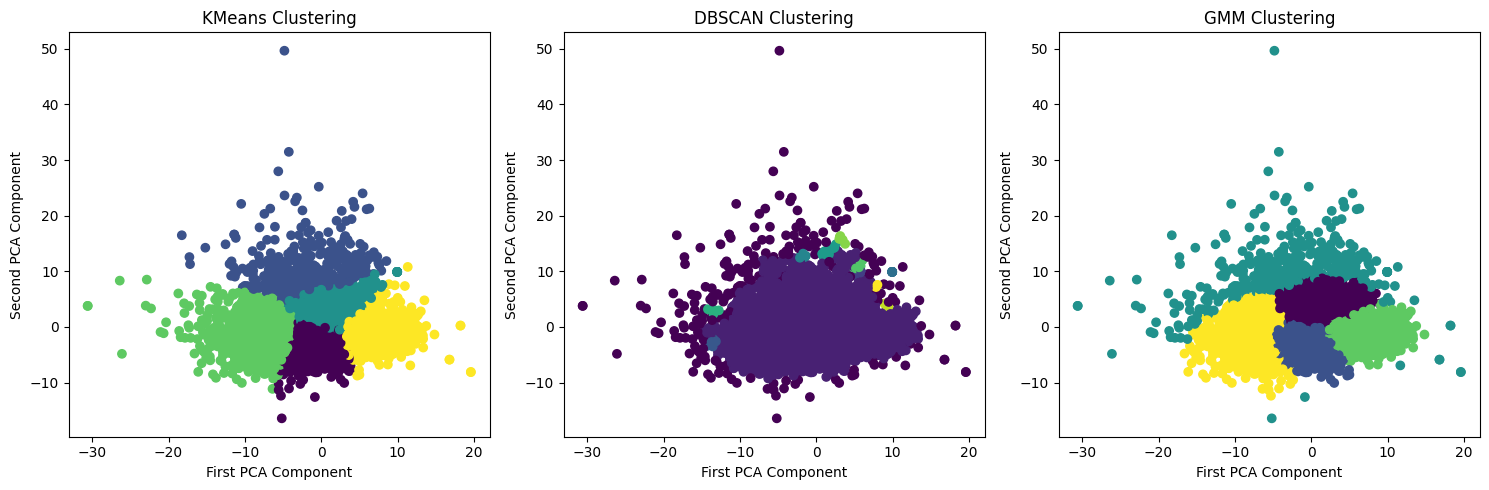


=== PCA-based Model Performance ===
PCA Accuracy: 0.3522531819745442

PCA Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.05      0.08      4564
           1       0.40      0.51      0.45      4714
           2       0.51      0.61      0.55      4748
           3       0.34      0.12      0.18      4606
           4       0.25      0.45      0.32      4624

    accuracy                           0.35     23256
   macro avg       0.33      0.35      0.32     23256
weighted avg       0.33      0.35      0.32     23256


=== DBSCAN-based Model Performance ===
DBSCAN Accuracy: 0.1937564499484004

DBSCAN Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.20      0.99      0.33      4564
           1       0.00      0.00      0.00      4714
           2       0.00      0.00      0.00      4748
           3       0.17      0.00  

/Users/emilygelchie/miniconda3/envs/cornellenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilygelchie/miniconda3/envs/cornellenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/emilygelchie/miniconda3/envs/cornellenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

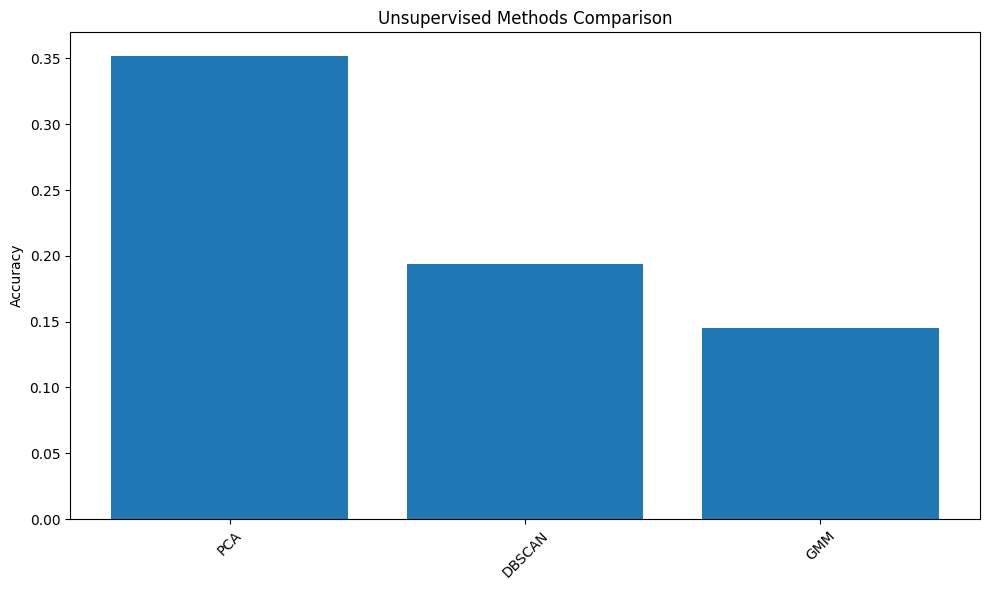

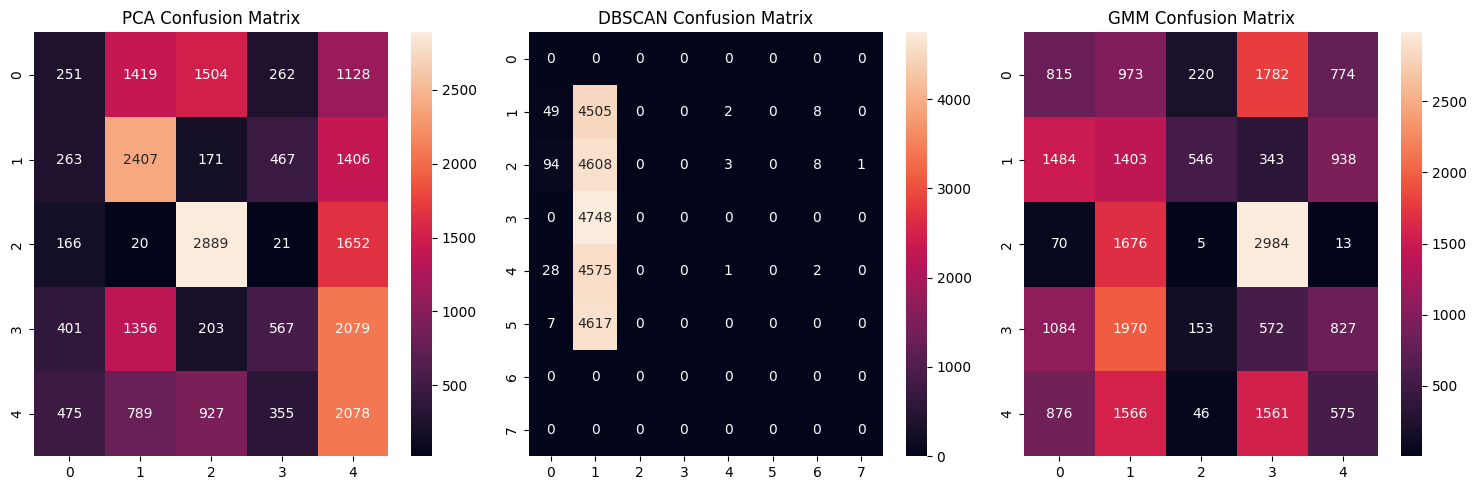


Results have been saved to 'unsupervised_results.json'


In [153]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# 1. Prepare text data with CountVectorizer
vectorizer = CountVectorizer(
    input="content",
    stop_words="english",
    min_df=3,
    max_features=1000,
)

# 2. Convert to numpy arrays and split
X_train_np = X_train  # Using the original X_train from CountVectorizer
y_train_np = y_train_clean  # Using matching labels

# 3. Split data into labeled and "unlabeled" portions
X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X_train_np, y_train_np, test_size=0.3, random_state=42
)

# 4. Preprocess data (Scaling)
scaler = StandardScaler()
X_unlabeled_scaled = scaler.fit_transform(X_unlabeled)
X_val_scaled = scaler.transform(X_val)

# 5. Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_unlabeled_pca = pca.fit_transform(X_unlabeled_scaled)
X_val_pca = pca.transform(X_val_scaled)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# 6. Apply KMeans clustering
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300, random_state=42)
kmeans_labels = kmeans.fit_predict(X_unlabeled_pca)

# 7. Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.8, min_samples=5, metric="euclidean")
dbscan_labels = dbscan.fit_predict(X_unlabeled_pca)

# 8. Apply GMM clustering
gmm = GaussianMixture(
    n_components=5, covariance_type="full", n_init=5, max_iter=200, random_state=42
)
gmm_labels = gmm.fit_predict(X_unlabeled_pca)

# 9. Analyze cluster distributions
print("\nKMeans Cluster Distribution:")
for i in range(5):
    print(f"Cluster {i}: {np.sum(kmeans_labels == i)} samples")

print("\nDBSCAN Cluster Distribution:")
unique_labels = np.unique(dbscan_labels)
for label in unique_labels:
    print(f"Cluster {label}: {np.sum(dbscan_labels == label)} samples")

print("\nGMM Cluster Distribution:")
for i in range(5):
    print(f"Cluster {i}: {np.sum(gmm_labels == i)} samples")

# 10. Visualize clusters
plt.figure(figsize=(15, 5))

# KMeans plot
plt.subplot(131)
plt.scatter(
    X_unlabeled_pca[:, 0], X_unlabeled_pca[:, 1], c=kmeans_labels, cmap="viridis"
)
plt.title("KMeans Clustering")
plt.xlabel("First PCA Component")
plt.ylabel("Second PCA Component")

# DBSCAN plot
plt.subplot(132)
plt.scatter(
    X_unlabeled_pca[:, 0], X_unlabeled_pca[:, 1], c=dbscan_labels, cmap="viridis"
)
plt.title("DBSCAN Clustering")
plt.xlabel("First PCA Component")
plt.ylabel("Second PCA Component")

# GMM plot
plt.subplot(133)
plt.scatter(X_unlabeled_pca[:, 0], X_unlabeled_pca[:, 1], c=gmm_labels, cmap="viridis")
plt.title("GMM Clustering")
plt.xlabel("First PCA Component")
plt.ylabel("Second PCA Component")

plt.tight_layout()
plt.show()
# 11. Evaluate PCA-based classification
print("\n=== PCA-based Model Performance ===")
lr_pca = LogisticRegression(max_iter=1000)
# Use PCA components directly for classification
lr_pca.fit(X_unlabeled_pca, y_unlabeled_true)
pca_pred = lr_pca.predict(X_val_pca)
print("PCA Accuracy:", accuracy_score(y_val, pca_pred))
print("\nPCA Classification Report:")
print(classification_report(y_val, pca_pred))

# 12. Evaluate DBSCAN-based classification
print("\n=== DBSCAN-based Model Performance ===")
lr_dbscan = LogisticRegression(max_iter=1000)
# Use DBSCAN labels for classification
lr_dbscan.fit(X_unlabeled_pca, dbscan_labels)
dbscan_pred = lr_dbscan.predict(X_val_pca)
print("DBSCAN Accuracy:", accuracy_score(y_val, dbscan_pred))
print("\nDBSCAN Classification Report:")
print(classification_report(y_val, dbscan_pred))

# 13. Evaluate GMM-based classification
print("\n=== GMM-based Model Performance ===")
lr_gmm = LogisticRegression(max_iter=1000)
# Use GMM labels for classification
lr_gmm.fit(X_unlabeled_pca, gmm_labels)
gmm_pred = lr_gmm.predict(X_val_pca)
print("GMM Accuracy:", accuracy_score(y_val, gmm_pred))
print("\nGMM Classification Report:")
print(classification_report(y_val, gmm_pred))

# 14. Compare all unsupervised methods
print("\n=== Unsupervised Methods Comparison ===")
unsupervised_results = {
    "PCA": accuracy_score(y_val, pca_pred),
    "DBSCAN": accuracy_score(y_val, dbscan_pred),
    "GMM": accuracy_score(y_val, gmm_pred),
}

for method, acc in unsupervised_results.items():
    print(f"{method} Accuracy: {acc:.4f}")

# 15. Visualize unsupervised method comparisons
plt.figure(figsize=(10, 6))
plt.bar(unsupervised_results.keys(), unsupervised_results.values())
plt.title("Unsupervised Methods Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 16. Create confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# PCA confusion matrix
cm_pca = confusion_matrix(y_val, pca_pred)
sns.heatmap(cm_pca, annot=True, fmt="d", ax=axes[0])
axes[0].set_title("PCA Confusion Matrix")

# DBSCAN confusion matrix
cm_dbscan = confusion_matrix(y_val, dbscan_pred)
sns.heatmap(cm_dbscan, annot=True, fmt="d", ax=axes[1])
axes[1].set_title("DBSCAN Confusion Matrix")

# GMM confusion matrix
cm_gmm = confusion_matrix(y_val, gmm_pred)
sns.heatmap(cm_gmm, annot=True, fmt="d", ax=axes[2])
axes[2].set_title("GMM Confusion Matrix")

plt.tight_layout()
plt.show()

# 17. Save results
np.save("pca_predictions.npy", pca_pred)
np.save("dbscan_predictions.npy", dbscan_pred)
np.save("gmm_predictions.npy", gmm_pred)

# 18. Save model performance metrics
results_dict = {
    "PCA": {
        "accuracy": accuracy_score(y_val, pca_pred),
        "confusion_matrix": cm_pca.tolist(),
    },
    "DBSCAN": {
        "accuracy": accuracy_score(y_val, dbscan_pred),
        "confusion_matrix": cm_dbscan.tolist(),
    },
    "GMM": {
        "accuracy": accuracy_score(y_val, gmm_pred),
        "confusion_matrix": cm_gmm.tolist(),
    },
}

import json

with open("unsupervised_results.json", "w") as f:
    json.dump(results_dict, f, indent=4)

print("\nResults have been saved to 'unsupervised_results.json'")

# Part 2: With your newly augmented dataset, re-run your supervised algorithms. How do the performance values change?

In [154]:
len(X_train)


24758

In [155]:
len(y_train_clean)


24758

In [156]:
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Define the number of clusters (same as the number of unique labels in y_train_clean)
n_clusters = len(
    np.unique(y_train_clean[y_train_clean != -100])
)  # Assuming -100 is the missing label

# Step 2: Fit K-Means on X_train
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

# Step 3: Assign pseudo-labels to the unlabeled data
# For example, assuming missing labels are represented as -100
pseudo_labels = kmeans.predict(X_train)
y_train_augmented = np.where(y_train_clean == -100, pseudo_labels, y_train_clean)


In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Step 1: Initialize the supervised model
model = LogisticRegression(max_iter=200, random_state=42)

# Step 2: Train the model on the fully labeled augmented dataset
model.fit(X_train, y_train_augmented)

# Step 3: Evaluate on a validation set or perform cross-validation (assuming X_val and y_val exist)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.79      0.80      4564
           1       0.74      0.65      0.69      4714
           2       0.95      0.96      0.96      4748
           3       0.71      0.75      0.73      4606
           4       0.82      0.86      0.84      4624

    accuracy                           0.80     23256
   macro avg       0.80      0.80      0.80     23256
weighted avg       0.80      0.80      0.80     23256



/Users/emilygelchie/miniconda3/envs/cornellenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [158]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train_augmented)
y_pred_rf = model_rf.predict(X_val)
print("Random Forest Classifier:\n", classification_report(y_val, y_pred_rf))


Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      4564
           1       0.73      0.70      0.72      4714
           2       0.96      0.96      0.96      4748
           3       0.74      0.76      0.75      4606
           4       0.81      0.85      0.83      4624

    accuracy                           0.81     23256
   macro avg       0.81      0.81      0.81     23256
weighted avg       0.81      0.81      0.81     23256



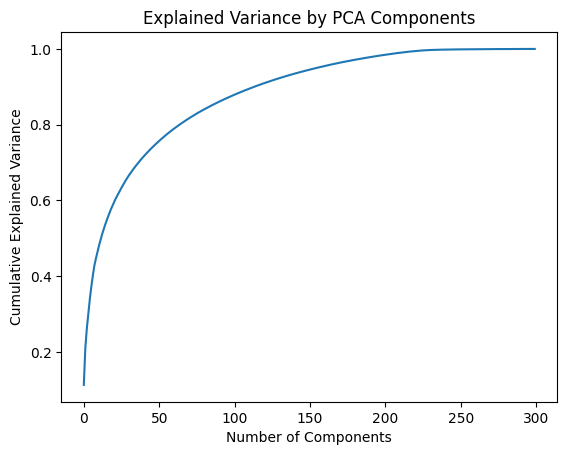

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on X_train and plot cumulative variance
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.show()


In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=50, random_state=42)  # Adjust n_components based on the dataset
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Step 2: Define Random Forest and Hyperparameter Search Space
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# Initialize Random Forest Classifier
model_rf = RandomForestClassifier(random_state=42)

# Step 3: Apply RandomizedSearchCV for hyperparameter tuning
search = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of different combinations to try
    cv=5,  # Cross-validation splitting
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

# Fit the model on the training data with PCA
search.fit(X_train_pca, y_train_augmented)

# Get the best estimator
best_rf = search.best_estimator_
print("Best parameters found: ", search.best_params_)

# Step 4: Evaluate on validation set
y_pred_rf = best_rf.predict(X_val_pca)
print(
    "Random Forest Classifier with PCA and Hyperparameter Tuning:\n",
    classification_report(y_val, y_pred_rf),
)


Best parameters found:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Random Forest Classifier with PCA and Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79      4564
           1       0.74      0.70      0.72      4714
           2       0.97      0.94      0.96      4748
           3       0.74      0.78      0.76      4606
           4       0.81      0.85      0.83      4624

    accuracy                           0.81     23256
   macro avg       0.81      0.81      0.81     23256
weighted avg       0.81      0.81      0.81     23256



In [161]:
from sklearn.model_selection import GridSearchCV

# Define a more focused grid around the best found parameters
param_grid = {
    "n_estimators": [250, 300, 350],
    "max_depth": [15, 20, 25],
    "min_samples_split": [2, 3],
    "min_samples_leaf": [3, 4, 5],
    "bootstrap": [False],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
)
grid_search.fit(X_train_pca, y_train_augmented)

best_rf = grid_search.best_estimator_
print("Refined parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=250; total time=  42.9s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=250; total time=  42.9s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=250; total time=  43.0s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=250; total time=  43.0s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=250; total time=  43.2s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=3, n_estimators=250; total time=  43.6s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  50.9s
[CV] END bootstrap=False, max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=300; total time=  

In [162]:
from sklearn.svm import SVC

model_svc = SVC(kernel="linear", random_state=42)
model_svc.fit(X_train, y_train_augmented)
y_pred_svc = model_svc.predict(X_val)
print("Support Vector Classifier:\n", classification_report(y_val, y_pred_svc))


Support Vector Classifier:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      4564
           1       0.73      0.68      0.70      4714
           2       0.96      0.96      0.96      4748
           3       0.73      0.75      0.74      4606
           4       0.85      0.86      0.85      4624

    accuracy                           0.81     23256
   macro avg       0.81      0.81      0.81     23256
weighted avg       0.81      0.81      0.81     23256



In [163]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train_augmented)
y_pred_gb = model_gb.predict(X_val)
print("Gradient Boosting Classifier:\n", classification_report(y_val, y_pred_gb))


Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      4564
           1       0.72      0.68      0.70      4714
           2       0.94      0.95      0.94      4748
           3       0.71      0.74      0.72      4606
           4       0.80      0.84      0.82      4624

    accuracy                           0.79     23256
   macro avg       0.79      0.79      0.79     23256
weighted avg       0.79      0.79      0.79     23256



In [164]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train_augmented)
y_pred_knn = model_knn.predict(X_val)
print("K-Nearest Neighbors:\n", classification_report(y_val, y_pred_knn))


K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      4564
           1       0.76      0.70      0.73      4714
           2       0.97      0.99      0.98      4748
           3       0.77      0.81      0.79      4606
           4       0.87      0.86      0.87      4624

    accuracy                           0.84     23256
   macro avg       0.84      0.84      0.84     23256
weighted avg       0.84      0.84      0.84     23256



X_train shape: X_train not defined
y_train_augmented shape: y_train_augmented not defined
Please run the data preparation steps first to create X_train and y_train_augmented
